## Compare model performance on ADS and individual tree mortality

In [2]:
!pip install -q xarray-spatial

In [3]:
import xarray as xr
import rioxarray
import rioxarray.merge
import xrspatial
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics
from glob import glob

Combine the individual tree mortality rasters into one dataset.

In [4]:
# Read everything in
damage_files = glob("../data_in/nmschroeder_mortality/*_mortality*.tif")
damage_arrs  = []

for f in damage_files:
    year = int(f.split("_")[-1][:4])
    arr = rioxarray.open_rasterio(f)
    arr = arr.squeeze(drop=True)
    arr = arr.expand_dims(time=1)
    arr = arr.assign_coords(time=[year])
    damage_arrs.append(arr)

In [5]:
# Merge datasets from the same time period in space
spatial_merge_arrs = []
unique_years = set(a.time.values[0] for a in damage_arrs)
for y in unique_years:
    arrs_to_merge = list(filter(lambda x: x.time.values[0] == y, damage_arrs))
    merged = rioxarray.merge.merge_arrays(arrs_to_merge)
    spatial_merge_arrs.append(merged)

In [6]:
# Merge datasets across years and set NAs
itm_ds = xr.combine_by_coords(spatial_merge_arrs)
itm_ds = itm_ds.where(itm_ds != itm_ds.attrs["_FillValue"])

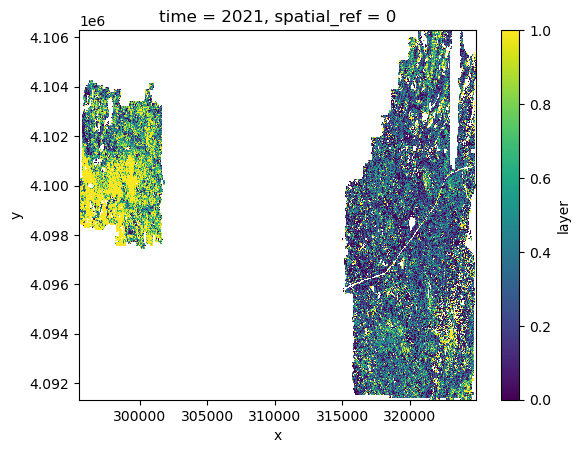

In [7]:
itm_ds.isel(time=-1).plot()

Aerial mortality and ancillary data.

In [9]:
ads_ds = xr.open_dataset("../mort_datasets/soap_teak_mort.nc").drop_vars("spatial_ref")
ads_ds

<xarray.Dataset> Size: 720MB
Dimensions:      (time: 23, y: 499, x: 980)
Coordinates:
  * time         (time) int64 184B 2000 2001 2002 2003 ... 2019 2020 2021 2022
  * x            (x) float64 8kB 2.955e+05 2.956e+05 ... 3.249e+05 3.249e+05
  * y            (y) float64 4kB 4.106e+06 4.106e+06 ... 4.091e+06 4.091e+06
Data variables: (12/15)
    elev         (time, y, x) float32 45MB ...
    slope        (time, y, x) float32 45MB ...
    northness    (time, y, x) float32 45MB ...
    eastness     (time, y, x) float32 45MB ...
    fire         (time, y, x) float32 45MB ...
    prcp         (time, y, x) float32 45MB ...
    ...           ...
    treecover    (time, y, x) float32 45MB ...
    abies        (time, y, x) float32 45MB ...
    pinus        (time, y, x) float64 90MB ...
    populus      (time, y, x) float32 45MB ...
    pseudotsuga  (time, y, x) float32 45MB ...
    tsuga        (time, y, x) float32 45MB ...

Multiply mortality rasters by tree density. This means our target variable is number of dead trees per pixel.

In [10]:
trees_per_px = rioxarray.open_rasterio("../data_in/nmschroeder_mortality/trees_per_pixel.tif").squeeze(drop=True)
tree_mask = trees_per_px > 0

# Mask out nonforested pixels
itm_ds = itm_ds.where(tree_mask)
ads_ds = ads_ds.where(tree_mask)

In [11]:
ads_ds["itm_norm"] = itm_ds * trees_per_px
ads_ds["ads_norm"] = ads_ds["mortality"] / 100 * trees_per_px

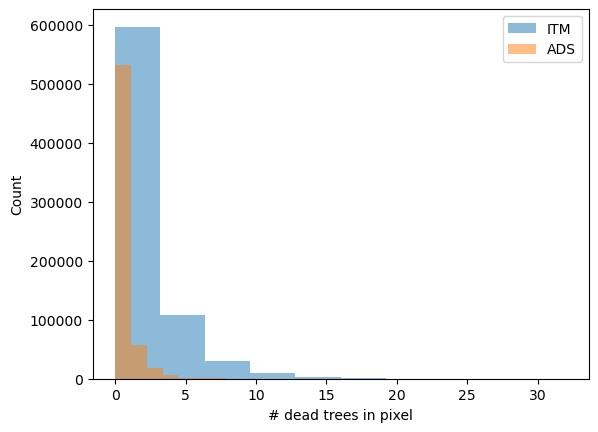

In [14]:
fig, ax = plt.subplots()
ads_ds["itm_norm"].plot.hist(ax=ax, label="ITM", alpha=0.5)
# Plot a slice to get similar pixel count
ads_ds["ads_norm"].isel(time=slice(-5, None)).plot.hist(ax=ax, label="ADS", alpha=0.5)
plt.legend()
plt.xlabel("# dead trees in pixel")
plt.ylabel("Count")
plt.title("")
plt.show()

Prepare covariates - focal max mortality, heat load index

In [15]:
ads_ds["ads_focal_max"] = (("time", "y", "x"), scipy.ndimage.maximum_filter(ads_ds["ads_norm"].values, size=(1, 5, 5)))
ads_ds["itm_focal_max"] = (("time", "y", "x"), scipy.ndimage.maximum_filter(ads_ds["itm_norm"].values, size=(1, 5, 5)))

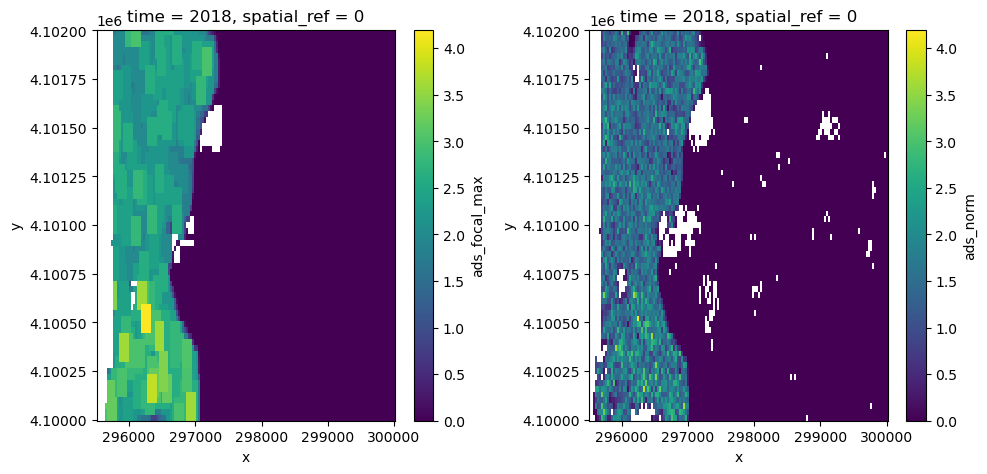

In [16]:
# Check that focal max worked as expected
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

window = dict(y=slice(4.102e6, 4.100e6), x=slice(None, 300_000), time=2018)

ads_ds.sel(**window).ads_focal_max.plot(ax=ax1)
ads_ds.sel(**window).ads_norm.plot(ax=ax2)
plt.tight_layout()
plt.show()

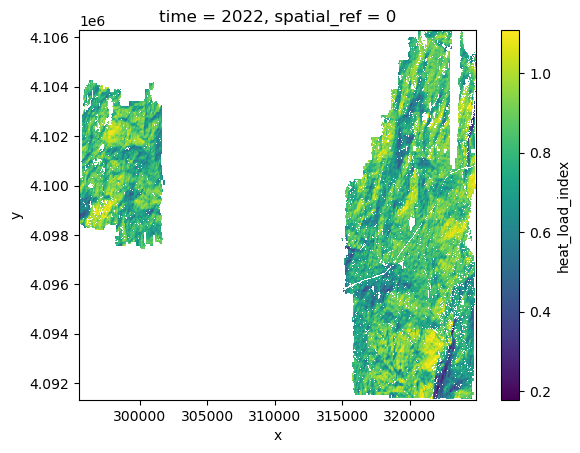

In [17]:
# Heat load index comes from 
# https://doi.org/10.1111/j.1654-1103.2002.tb02087.x
latitude = 37 * np.pi / 180 # deg north, essentially constant
ads_ds["heat_load_index"] = -1.467 +\
     1.582 * np.cos(latitude) * np.cos(ads_ds["slope"] * np.pi / 180)+\
    -1.500 * ads_ds["eastness"]/100 * np.sin(ads_ds["slope"] * np.pi / 180) * np.sin(latitude)+\
    -0.262 * np.sin(latitude) * np.sin(ads_ds["slope"] * np.pi / 180)+\
     0.607 * ads_ds["northness"]/100 * np.sin(ads_ds["slope"] * np.pi / 180)
ads_ds["heat_load_index"] = np.exp(ads_ds["heat_load_index"])
ads_ds.isel(time=-1).heat_load_index.plot()

Prepare training data. Train on 2017 using data from 2014 - 2016, then validate on 2021 using data from 2018 - 2020. No temporal dimension in the xarray objects.

In [26]:
# First collect all the time-constant variables
const_vars = ["elev", "abies", "pinus", "heat_load_index"]
ads_const  = ads_ds[const_vars].sel(time=2000)
ads_const

<xarray.Dataset> Size: 10MB
Dimensions:          (y: 499, x: 980)
Coordinates:
    time             int64 8B 2000
  * x                (x) float64 8kB 2.955e+05 2.956e+05 ... 3.249e+05 3.249e+05
  * y                (y) float64 4kB 4.106e+06 4.106e+06 ... 4.091e+06 4.091e+06
    spatial_ref      int64 8B 0
Data variables:
    elev             (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    abies            (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    pinus            (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan
    heat_load_index  (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan

In [27]:
# Collect all the climatology variables and summarize
train_period = slice(2014, 2017)
valid_period = slice(2018, 2021)

climate_vars = ["prcp", "vp", "tmin"]

train_climate = ads_ds.sel(time=train_period)[climate_vars].mean(dim="time")
valid_climate = ads_ds.sel(time=valid_period)[climate_vars].mean(dim="time")

In [39]:
# Collect baseline mortality at the start of the period, 
# and mortality at the end of the period we are trying to predict
mort_vars = ["ads_norm", "itm_norm"]
focal_max = ["ads_focal_max", "itm_focal_max"]
train_baseline = ads_ds[mort_vars + focal_max].rename(ads_norm="ads_baseline", itm_norm="itm_baseline").sel(time=2013)
valid_baseline = ads_ds[mort_vars + focal_max].rename(ads_norm="ads_baseline", itm_norm="itm_baseline").sel(time=2018)

train_target = ads_ds[mort_vars].rename(ads_norm="ads_target", itm_norm="itm_target").sel(time=2017)
valid_target = ads_ds[mort_vars].rename(ads_norm="ads_target", itm_norm="itm_target").sel(time=2021)

In [40]:
# Assemble data together
train_ds = xr.merge([ads_const, train_climate, train_baseline, train_target], compat="override")
valid_ds = xr.merge([ads_const, valid_climate, valid_baseline, valid_target], compat="override")

Define naive models. Our time step is longer here than when working with west mort so we the "baseline" vars already count as last obs. For spatial average we can take the mean over the train/validation periods.

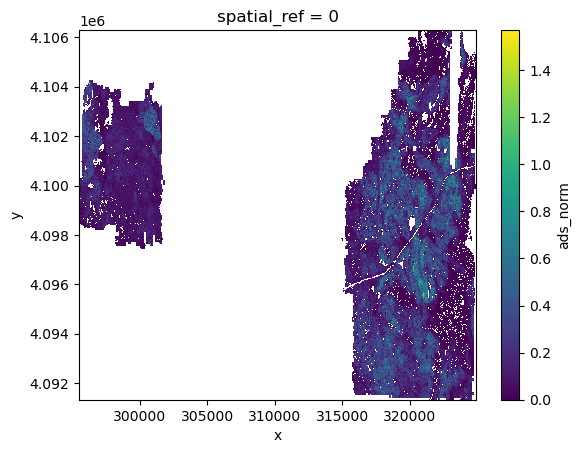

In [42]:
ads_spatial_average = ads_ds["ads_norm"].mean(dim="time")
itm_spatial_average = ads_ds["itm_norm"].mean(dim="time")
ads_spatial_average.plot()

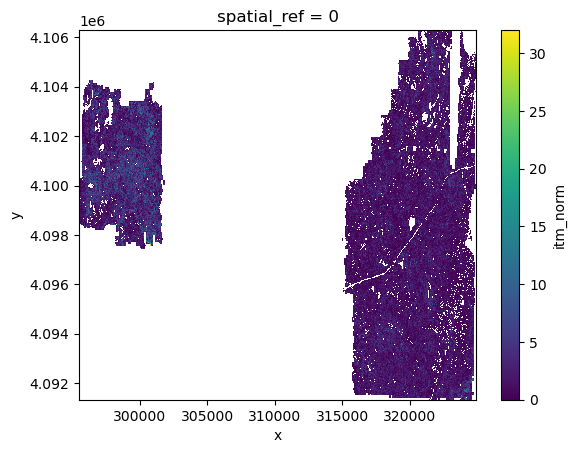

In [43]:
itm_spatial_average.plot()

Now convert all the objects to data frames.

In [61]:
train_df = train_ds.to_dataframe().reset_index(drop=True).dropna()
train_df["itm_delta"] = train_df["itm_target"] - train_df["itm_baseline"]
valid_df = valid_ds.to_dataframe().reset_index(drop=True).dropna()
valid_df["itm_delta"] = valid_df["itm_target"] - valid_df["itm_baseline"]

In [46]:
train_df.columns

Index(['elev', 'abies', 'pinus', 'heat_load_index', 'time', 'spatial_ref',
       'prcp', 'vp', 'tmin', 'ads_baseline', 'itm_baseline', 'ads_focal_max',
       'itm_focal_max', 'ads_target', 'itm_target'],
      dtype='object')

In [62]:
common_vars = ["heat_load_index", "elev", "prcp", "vp", "tmin", "abies", "pinus"]

itm_vars = ["itm_baseline", "itm_focal_max"]
ads_vars = ["ads_baseline", "ads_focal_max"]

itm_target = ["itm_delta"]
ads_target = ["ads_target"]

def split_xy(df, target):
    return (
        df.reset_index(drop=True).drop(columns=target).to_numpy(),
        df.reset_index(drop=True)[target].to_numpy().flatten()
    )

X_ads_train, y_ads_train = split_xy(train_df[common_vars+ads_vars+ads_target], ads_target)
X_itm_train, y_itm_train = split_xy(train_df[common_vars+itm_vars+itm_target], itm_target)

In [63]:
rf_ads = RandomForestRegressor(oob_score=True)
rf_itm = RandomForestRegressor(oob_score=True)

rf_ads.fit(X_ads_train, y_ads_train)
rf_itm.fit(X_itm_train, y_itm_train)

RandomForestRegressor(oob_score=True)

In [64]:
from sklearn.metrics import mean_squared_error

def get_results(y, y_hat):
    mse = mean_squared_error(y_hat, y)
    nrmse = mse / np.std(y)
    r = np.corrcoef(y, y_hat)[0, 1]
    return {
        "mse": mse,
        "nrmse": nrmse,
        "r": r
    }

print("ADS model")
print(get_results(y_ads_train, rf_ads.oob_prediction_))

print("ITM model")
print(get_results(y_itm_train, rf_itm.oob_prediction_))

ADS model
{'mse': 0.7417341515111692, 'nrmse': 0.457830062978764, 'r': 0.8480361319476142}
ITM model
{'mse': 3.806217892469564, 'nrmse': 1.5414768934676397, 'r': 0.619820350377658}


In [65]:
X_ads_valid, y_ads_valid = split_xy(valid_df[common_vars+ads_vars+ads_target], ads_target)
X_itm_valid, y_itm_valid = split_xy(valid_df[common_vars+itm_vars+itm_target], itm_target)

y_hat_itm = rf_itm.predict(X_itm_valid)
y_hat_ads = rf_ads.predict(X_ads_valid)

print("ADS model")
print(get_results(y_ads_valid, y_hat_ads))

print("ITM model")
print(get_results(y_itm_valid, y_hat_itm))

ADS model
{'mse': 2.692018175750677, 'nrmse': 6.203775803793587, 'r': 0.10643382865071087}
ITM model
{'mse': 4.30617143522107, 'nrmse': 2.958955047653521, 'r': 0.26378881378331603}


Calculate naive model performance

In [58]:
print("ADS baseline")
print(get_results(valid_df["ads_target"], valid_df["ads_baseline"]))

print("ITM baseline")
print(get_results(valid_df["itm_target"], valid_df["itm_baseline"]))

ADS baseline
{'mse': 2.0465564727783203, 'nrmse': 4.716304533634462, 'r': 0.12660995207464124}
ITM baseline
{'mse': 2.389782667160034, 'nrmse': 0.8912884968500051, 'r': 0.8404961344204368}


In [60]:
# These arrays have the same shape so we can happily flatten them and mask
itm_avg_flat = itm_spatial_average.data.flatten()
ads_avg_flat = ads_spatial_average.data.flatten()

itm_target_flat = valid_ds.itm_target.data.flatten()
ads_target_flat = valid_ds.ads_target.data.flatten()

itm_mask = ~(np.isnan(itm_avg_flat) | np.isnan(itm_target_flat))
ads_mask = ~(np.isnan(ads_avg_flat) | np.isnan(ads_target_flat))

print("ITM spatial average")
print(get_results(itm_target_flat[itm_mask], itm_avg_flat[itm_mask]))

print("ADS spatial average")
print(get_results(ads_target_flat[ads_mask], ads_avg_flat[ads_mask]))

ITM spatial average
{'mse': 1.8261526823043823, 'nrmse': 0.6898345707883756, 'r': 0.9183832125058428}
ADS spatial average
{'mse': 0.1671215146780014, 'nrmse': 0.3862140343542877, 'r': 0.35485588392201833}
